<a href="https://www.kaggle.com/code/binfeng2021/regression-problem-house-price-prediction?scriptVersionId=165598102" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Problem Statement

Among all versions of American dreams that are out there, one of the most frequently appeared terms would be homeowner. For many people, owning a home is a big deal not only financially, but in the whole life journey. However, it is not a easy process to obtain a house that fits your personal and financial needs. One of the major factor to consider would be the price of the house. 

The goal of this project is to develop a tool to estimate house price using some basic information that can be easily accessed. Of course the estimation cannot be alwasys accurate due to many other factors can play a big part in the prices, but the home buyer can at least have a good start point for the price negotiations process. 

This project will contain three main parts:
- Exploratory Data Analysis (EDA)
- Feature Engineering
- Model development 

# Dataset Info

## Content
The main data source for this project is a csv file that contains real estate listings in different areas of the US. It contains 10 columns showing as below:
* status: house status, either for sale or ready to build
* bed: number of bedrooms in the house
* bath: number of bathroom in the house
* acre_lot: property / land size in acres
* city: City the house residents in
* state: State the house residents in
* zip_code: postal code of the area
* house_size: house size in square feet
* prev_sold_date: the previously sold date if it is recently sold
* price: house prices (either current listing price or recently sold price)

## Acknowledgements
The data was collected from [realtor.com](https://www.realtor.com/) and special thanks to [Ahmed Shahriar Sakib](https://www.kaggle.com/ahmedshahriarsakib) for the efforts of mataining the dataset in Kaggle. 

More details about the dataset can be found: 
[USA Real Estate Dataset](https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset)

In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [ ]:
import plotly.offline as py
py.init_notebook_mode(connected = True)

In [ ]:
import datetime

In [ ]:
import string
import warnings
warnings.filterwarnings('ignore')

df_data = pd.read_csv('/kaggle/input/usa-real-estate-dataset/realtor-data.zip.csv')

# Exploratory Data Analysis

### First Glance of the dataset

In [ ]:
df_data.head(3)

There are 10 variables including the target variables pricing, five numerical variables and four categorical variables.

In [ ]:
print(f"Numerical variables in dataset: {df_data.select_dtypes(exclude = ['object']).columns.tolist()}")
print(f"Categorical variables in dataset: {df_data.select_dtypes(include = ['object']).columns.tolist()}")

In [ ]:
df_data.describe().T

Note that there are some variables that are in numerical format, but actually should be categorial variables, like **zip code**. The **number of bedrooms and bathrooms** should be treated as categorial variables as well since those values are discreate, not continuous. 

There are missing values in the dataset that we need to deal with before we can build any machine learning models. The missing values counts in each variable shown below:

In [ ]:
df_data.isnull().sum()

Noticed that there are 71 missing values in the target variables **pricing**. Since the main objective of this project is to predict the price, we will remove any records with a missing pricing values. 

In [ ]:
df_data.dropna(subset = 'price', inplace=True)

### where are the samples collected?

In [ ]:
ds_sample_counts = df_data.groupby('state').size().sort_values(ascending=False)

In [ ]:
fig = plt.pie(data = ds_sample_counts, x= ds_sample_counts.values,
           labels = ds_sample_counts.index)

Note that most of the samples are collected in New York, New Jersey, Massachusetts and Connecticut. 

### Target variable

In [ ]:
df_data.price.describe()

In [ ]:
sns.boxplot(df_data, x = 'price')

It is difficult to see the actual distribution of the target variable due to the outliers. We will remove those outliers and create the box plot again. 

To remove the outlier for better visualization, we will remove the top 10% of high prices. 

In [ ]:
outlier_cutoff = df_data.price.quantile(0.9)
sns.boxplot(df_data[df_data['price']<outlier_cutoff], x = 'price')

### median home prices in different location
**Median home prices in different states**

In [ ]:
df = df_data.groupby('state', as_index=False)['price'].median().sort_values('price', ascending=False)
sns.barplot(data = df, x = 'price', y = 'state')

**Median home prices in top 10 most expensive cities**

In [ ]:
df = df_data.groupby(['city', 'state'], as_index=False)['price'].median().sort_values('price', ascending=False).head(10)
df['city-state'] = df['city'] + '-' +df['state'] 
sns.barplot(data = df, x = 'price', y = 'city-state')

**Median home prices in top 10 most expensive zip codes**

In [ ]:
df = df_data.groupby(['zip_code', 'state'], as_index=False)['price'].median().sort_values('price', ascending=False).head(10)
df['zip_code-state'] = df['zip_code'].astype(int).astype(str) + '-' +df['state'] 
sns.barplot(data = df, x = 'price', y = 'zip_code-state')

From the bar chat above, we can clearly see how big the impact the location has on the house prices. 
* From states level, we can see that New York and Massachusetts are the two most expensive states. 
* For top 10 most expensive cities, we have four cities from Massachusetts, three from New Jersey, two from New York and one from Maine.
* For the top 10 most expensive zip code, we have give 5 in Massachusetts, two in New York, one in Connecticut, Vermont and New Jersey. 

### Home prices related to the house status
**Number of bedrooms**

In [ ]:
# to visualize how the num of bedroom could affect on the home price,
# we will combine the samples with 10 or above bedrooms together, since we only have limited amount of samples like that in the dataset
df = df_data.copy()
df.loc[df['bed']>=10, 'bed'] = 10
df_price_bed = df.groupby('bed', as_index=False)['price'].median()
sns.barplot(df_price_bed, x = 'bed', y = 'price')

When we just look at the median home price verse the number of bedrooms, we see a general up trend which means that the more bedrooms a house has, the higher median price is. **However, there is something seems odd which the median home price for one bedroom is higher that two bedrrom and three bedroom houses.**

My current thought is that there are several high living cost cities in the dataset and it generally has more one bedroom houses existed, and those could be the reason why the median price for one bedroom get skewed higher. We can dive deeper to see if this is the case.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (12,5))
df_data[df_data['bed']==1].state.value_counts().plot.pie(ax = ax[0], title = 'House market for one bedroom')
df_data[df_data['bed'].isin([2, 3])].state.value_counts().plot.pie(ax = ax[1], title = 'House market for two or three bedrooms')

From the two pie charts, we can see that New York takes a much bigger potio in the one bed room house market comparing to the market for two or three bedrooms. And from the analysis prior, we know that New York is the most expensive state for housing in our data, and that explains well why we see median home price for one bedroom is higher than two or three bedroom houses. 

# Feature Engineering

Here we will clean and preprocess the given dataset. To aviod data leaking from training to testing sets is perform the feature engineering on training and testing data seperately. 

In the following section, I will test some feature enginerring methods to make the data as clean and ready as possible for model training. 

first, we will drop the samples that does not contains much valuable information, meaning there are null values for all following columns: 
* house size, 
* bedroom counts, 
* bathroom counts 
* acre lot

In [ ]:
def remove_with_all_missing(df):
    '''
    Remove the records when all important features are missing,
    Here, I removed reocrds when housing size, bedroom, bathroom and acre lot are missing
    '''
    df = df[(~df['house_size'].isnull()) 
        | (~df['bed'].isnull()) 
        | (~df['bath'].isnull()) 
        | (~df['acre_lot'].isnull())]
    return df

In [ ]:
df_data = remove_with_all_missing(df_data)

## first, seperate training and testing data

In [ ]:
df_train, df_test = train_test_split(df_data,test_size = 0.1)

## Perform Feature Engineering to the Training Dataset
### Fill Missing values for training data

In [ ]:
df_train.isnull().sum()

**1. fill missing values for bedroom and bathroom**

In [ ]:
corr_mx = df_train.corr()
sns.heatmap(corr_mx, annot = True, cmap = 'coolwarm')

**See from the above correlation matrix, bedrooms and bathrooms counts are highly correlated. So we can use one to help fill missing values for another. 
Also, for the rest missing values, we can fill with the most frequently appeared values for the zip code, since we normally see similar house structure or size within the same neighborhood.**

Here are some thoughts about filling the missing values for bedroom and bathroom columns:
1. We can find out the median values for bedroom / bathroom counts using bathroom/bedroom or zip code as group
2. Fill the missing values for bedroom or bathroom with median values

In [ ]:
def filling_bed_bath(df):
    # first, obtain the most frequent bedroom counts using bathroom or zip code as group
    # similarity find the most frequent bathroom counts using bedroom or zip code as group
    df_mode_bed_per_bath = df.groupby(['bath'], as_index=False)['bed'].median().rename(columns = {'bed':'fill_bed_with_bath'})
    df_bed_per_zip = df.groupby('zip_code', as_index=False)['bed'].median().rename(columns = {'bed':'fill_bed_with_zip'})
    df_mode_bath_per_bath = df.groupby(['bed'], as_index=False)['bath'].median().rename(columns = {'bath':'fill_bath_with_bed'})
    df_bath_per_zip = df.groupby('zip_code', as_index=False)['bath'].median().rename(columns = {'bath':'fill_bath_with_zip'})

    df = df.merge(df_mode_bed_per_bath, on = ['bath'], how='left').merge(df_bed_per_zip, on = ['zip_code'], how='left')\
    .merge(df_mode_bath_per_bath, on = ['bed'], how='left').merge(df_bath_per_zip, on = ['zip_code'], how='left')

    # fill missing values for bedroom column with bathroom info
    df.loc[(df['bed'].isnull()) & (~df['fill_bed_with_bath'].isnull()), 'bed'] = df.loc[(df['bed'].isnull()) & (~df['fill_bed_with_bath'].isnull()), 'fill_bed_with_bath']
    # fill missing values for bathroom column with bedroom info
    df.loc[(df['bath'].isnull()) & (~df['fill_bath_with_bed'].isnull()), 'bath'] = df.loc[(df['bath'].isnull()) & (~df['fill_bath_with_bed'].isnull()), 'fill_bath_with_bed']

    # for the remaining, see if we can fill with zip code info
    df.loc[(df['bed'].isnull()) & (~df['fill_bed_with_zip'].isnull()), 'bed'] = df.loc[(df['bed'].isnull()) & (~df['fill_bed_with_zip'].isnull()), 'fill_bed_with_zip']
    df.loc[(df['bath'].isnull()) & (~df['fill_bath_with_zip'].isnull()), 'bath'] = df.loc[(df['bath'].isnull()) & (~df['fill_bath_with_zip'].isnull()), 'fill_bath_with_zip']

    df.drop(['fill_bed_with_bath','fill_bed_with_zip', 'fill_bath_with_bed', 'fill_bath_with_zip'], axis = 1, inplace=True)
    return df


In [ ]:
df_train = filling_bed_bath(df_train)

**Fill missing values for house size and acre lot**

* From the correlation matrix, we see the house size is correlated with bedroom and bathrooms counts. We will fill the house size based on those two features along with zip code.

* In general, within the same neighborhood, the lot size are similar from each property. Here, we will use that assumption and fill the missing values for acre_lot column using zip code info.

In [ ]:
def filling_house_size_lot(df):
    # first, obtain the median house size using bathroom bedroom counts as group
    # similarity find the median house size using zip code as group
    # find the median appeared lot size using zip code as group
    df_mode_house_size = df.groupby(['bath', 'bed'], as_index=False)['house_size'].median().rename(columns = {'house_size':'filled_house_size'})
    df_house_size_per_zip = df.groupby('zip_code', as_index=False)['house_size'].median().rename(columns = {'house_size':'fill_house_size_with_zip'})
    df_lot_per_zip = df.groupby('zip_code', as_index=False)['acre_lot'].median().rename(columns = {'acre_lot':'fill_acre_lot_with_zip'})

    df = df.merge(df_mode_house_size, on = ['bath', 'bed'], how='left').merge(df_house_size_per_zip, on = ['zip_code'], how='left')\
    .merge(df_lot_per_zip, on = ['zip_code'], how='left')

    # fill missing values for house size
    df.loc[(df['house_size'].isnull()) & (~df['filled_house_size'].isnull()), 'house_size'] = df.loc[(df['house_size'].isnull()) & (~df['filled_house_size'].isnull()), 'filled_house_size']
    df.loc[(df['house_size'].isnull()) & (~df['fill_house_size_with_zip'].isnull()), 'house_size'] = df.loc[(df['house_size'].isnull()) & (~df['fill_house_size_with_zip'].isnull()), 'fill_house_size_with_zip']

    # fill missing values for lot size
    df.loc[(df['acre_lot'].isnull()) & (~df['fill_acre_lot_with_zip'].isnull()), 'acre_lot'] = df.loc[(df['acre_lot'].isnull()) & (~df['fill_acre_lot_with_zip'].isnull()), 'fill_acre_lot_with_zip']
    df.drop(['filled_house_size','fill_house_size_with_zip', 'fill_acre_lot_with_zip'], axis = 1, inplace=True)
    return df

In [ ]:
df_train = filling_house_size_lot(df_train)

**Drop the remaining missing values if there is not many**

1. colum pre_sold_date have many missing values and also it does not have any significant correlation with the house price. We will drop it from this analysis.
2. If the remaining data still has missing values, fill in with the most frequent values

In [ ]:
df_train.drop('prev_sold_date', axis = 1, inplace = True)

In [ ]:
for col in df_train.columns:
    df_train[col] = df_train[col].fillna(df_train[col].mode()[0])

**After we filled the missing values and removed rows with any missing values, we end with a data frame without any missing values.**

In [ ]:
df_train.isnull().sum().sum()

### Convert feature types

As we have mentioned previously, there are some variables that are in numerical format, but actually should be categorial variables, like **zip code**. The **number of bedrooms and bathrooms** should be treated as categorial variables as well since those values are discreate, not continuous. 

For the following features, we will convert them to categirical features to better present the true meanings.
* status
* city
* state

We will use label encoding to convert city and state while use one hot encoding for status. 
1. Since one hot encoding will expand the features to multi dimension, and we have many different states and cities in the dataset, we will choose label encoding to limit the features amount to aviod potential overfitting.
2. One hot encoding technic is a good option for categorical features with no perticular orders, and it could be good choice for the feature status. 

In [ ]:
# label encoding for city and state
label_encoder = LabelEncoder()
df_train['city'] = label_encoder.fit_transform(df_train['city'])
df_train['state'] = label_encoder.fit_transform(df_train['state'])
# one hot encoding for status
df_train = pd.get_dummies(df_train, columns = ['status'])

After cleaning and preprocessing the dataset, we are now ready to move to model building.

In [ ]:
df_train.reset_index(drop = True, inplace = True)

In [ ]:
df_train.corr().price.sort_values(ascending=False).plot.bar()

# Model Development

**First, get training and validation data ready**

In [ ]:
X = df_train.drop('price', axis = 1)
y = df_train['price']
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size = 0.2)

In [ ]:
def get_scores(true_y, pred_y, model_name, all_performances):
    all_performances['model_name'].append(model_name)
    all_performances['MAE'].append(mean_absolute_error(true_y, pred_y))
    all_performances['MSE'].append(mean_squared_error(true_y, pred_y))
    all_performances['R2-Score'].append(r2_score(true_y, pred_y))

In [ ]:
all_performances = {'model_name':[],'MAE':[], 'MSE':[], 'R2-Score':[]}

**Second, we will develop a baseline model using median home price for each zip code. In case there are some missing zip code in the validation set, we will fill them with median home price for all areas.**

In [ ]:
# use training set only to get the median home prices for each zip code
training_data = pd.concat([train_X, train_y], axis = 1)
df_median_per_zipcode = training_data.groupby('zip_code', as_index=False)['price'].median()

median_home_price = training_data['price'].median()

df_base_line = val_X.merge(df_median_per_zipcode, on='zip_code', how='left')
df_base_line.loc[df_base_line['price'].isnull(), 'price'] = median_home_price

get_scores(val_y, df_base_line.price, 'Baseline using Median Values', all_performances)

## Machine Learning Models

**First model: Linear Regression**

In [ ]:
LR = make_pipeline(StandardScaler(), LinearRegression())
LR.fit(train_X, train_y)

y_pred = LR.predict(val_X)
get_scores(val_y, y_pred, 'Linear Regression', all_performances)

**Second model: Ridge Regression Model**

Similarly to Linear Regression, ridge regression coefficients tries to minimize a penalized residual sum of squares between the observed responses and the predicted values. It is a technique used when the data suffers from multicollinearity (which could be helpful in our case).

In [ ]:
RR = make_pipeline(StandardScaler(), Ridge())
RR.fit(train_X, train_y)
y_pred = RR.predict(val_X)
get_scores(val_y, y_pred, 'Ridge Regression', all_performances)

**Third model: Lasso (Least Absolute Shrinkage and Selection Operator)**

Lasso is a linear model that estimates sparse coefficients. Lasso model consists of a linear model trained with l1 prior as regularizer. Lasso is useful in some contexts due to its tendency to prefer solutions with fewer parameter values, effectively reducing the number of variables upon whihc the given solution is dependent.

In [ ]:
LASSO = make_pipeline(StandardScaler(), Lasso())
LASSO.fit(train_X, train_y)
y_pred = LASSO.predict(val_X)
get_scores(val_y, y_pred, 'LASSO Regression', all_performances)

**Fourth model: Random Forest Regression**

In [ ]:
RF = make_pipeline(StandardScaler(), RandomForestRegressor(n_jobs = -1))

In [ ]:
# Pipeline([('scaler', StandardScaler()), ('Random Forest Regressor', RandomForestRegressor())])
RF.fit(train_X, train_y)
y_pred = RF.predict(val_X)
get_scores(val_y, y_pred, 'Random Forest Regression', all_performances)

**Compare the models**

In [ ]:
df_performance = pd.DataFrame(all_performances)

In [ ]:
df_performance

In [ ]:
fig, axes = plt.subplots(3, 1, figsize = (8, 15))
sns.barplot(data = df_performance, y = 'model_name', x = 'MAE', ax = axes[0])

sns.barplot(data = df_performance, y = 'model_name', x = 'MSE', ax = axes[1])

sns.barplot(data = df_performance, y = 'model_name', x = 'R2-Score', ax = axes[2])

fig.show()

In [ ]:
rf_performance = df_performance[df_performance['model_name']=='Random Forest Regression']
baseline_performance = df_performance[df_performance['model_name']=='Baseline using Median Values']

mae_diff = (rf_performance['MAE'].values[0] - baseline_performance['MAE'].values[0]) / baseline_performance['MAE'].values[0] * 100
mse_diff = (rf_performance['MSE'].values[0] - baseline_performance['MSE'].values[0]) / baseline_performance['MSE'].values[0] * 100
r2_diff = (rf_performance['R2-Score'].values[0] - baseline_performance['R2-Score'].values[0]) / baseline_performance['R2-Score'].values[0] * 100

print('Compare the random forest regression model with the base line performance: ')
print("MAE improvement: {}%".format(round(mae_diff, 2)))
print("MSE improvement: {}%".format(round(mse_diff, 2)))
print("R2-Score improvement: {}%".format(round(r2_diff, 2)))

### How to interprate the plots:

**MAE (mean absolute error) & MSE (mean squared error)**: 
1. MAE and MSE measure the average magnitude of errors between the predicted values and the actual values. MSE penalizes larger errors more heavily due to squaring. 
2. We noticed that three linear models (linear regression, ridge regression and lasso regression) have higher MAE values than the baseline while have similar MSE values. That told us that those three linear models' predictions are further away from the expected values, but the magnitude of the differences are similar comparing to the base line. 
3. Compared to other models and the base line, random forest regression model has show a significant improvement with much lower MAE and MSE values. 

**R2-Score**
1. R-squared represents the proportion of the variance in the dependent variable (target) that is predictable from the independent variables (features). Higher values of R2 indicate better model fit to the data, with a value of 1 indicating a perfect fit.
2. Those three linear models have similar R2-Scores as the base line, so we can conclude that those linear models do not explain the house price's variances any better than the base line. 
3. We can see a much better R2-score for random forest regression than other linear models and the base line. 

**Conclusion**
* Selected Linear models do not have good performances for this task, one of the reasons could be the non-linear relationship within the given dataset. 
* From the comparison, we are seeing that random forest regression has a significantly better performance compring to other linear models and the base line. So, we will continue to fine tune the random forest regression model to see if we can further the performance. 

## Hyperparameters Fine-tune

In [ ]:
# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [10, 50],
    'min_samples_leaf': [1, 2]
}

scoring = {"MAE":make_scorer(mean_absolute_error), "MSE":make_scorer(mean_squared_error), "R2-Score":make_scorer(r2_score)}
rf_regressor = RandomForestRegressor()
# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, n_jobs=-1, scoring = scoring, refit = 'R2-Score', verbose = 1)
grid_search.fit(train_X, train_y)

In [ ]:
# Extracting parameters and performance metrics from the grid search results
params = grid_search.cv_results_['params']
params_str = []
for param in params:
    param_str = f"min_samples_leaf: {param['min_samples_leaf']}, n_estimators: {param['n_estimators']}"
    params_str.append(param_str)
    
mean_test_MAE = grid_search.cv_results_['mean_test_MAE']
mean_test_MSE = grid_search.cv_results_['mean_test_MSE']
mean_test_R2 = grid_search.cv_results_['mean_test_R2-Score']

fig, axes = plt.subplots(1, 3, figsize = (15, 5), sharey=True)
sns.barplot(y = params_str, x = mean_test_MAE, ax = axes[0])
sns.barplot(y = params_str, x = mean_test_MSE, ax = axes[1])
sns.barplot(y = params_str, x = mean_test_R2, ax = axes[2])

axes[0].set_title('MAE')
axes[1].set_title('MSE')
axes[2].set_title('R2-Score')
fig.show()

In [ ]:
# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(val_X)
get_scores(val_y, y_pred, 'FT-Random Forest Regression', all_performances)

In [ ]:
df_performance = pd.DataFrame(all_performances)
default_rf_performance = df_performance[df_performance['model_name']=='Random Forest Regression']
ft_rf_performance = df_performance[df_performance['model_name']=='FT-Random Forest Regression']

mae_diff = (ft_rf_performance['MAE'].values[0] - default_rf_performance['MAE'].values[0]) / default_rf_performance['MAE'].values[0] * 100
mse_diff = (ft_rf_performance['MSE'].values[0] - default_rf_performance['MSE'].values[0]) / default_rf_performance['MSE'].values[0] * 100
r2_diff = (ft_rf_performance['R2-Score'].values[0] - default_rf_performance['R2-Score'].values[0]) / default_rf_performance['R2-Score'].values[0] * 100

In [ ]:
print('Compare the fine tuned random forest regression model with the default random forest regression model performance: ')
print("MAE improvement: {}%".format(round(mae_diff, 2)))
print("MSE improvement: {}%".format(round(mse_diff, 2)))
print("R2-Score improvement: {}%".format(round(r2_diff, 2)))

The best model found using grid search shows a slightly improvement in the MAE score and R2-score, but a decrease in performance in MSE score. It shows that the new model is able to generate a slightly better prediction for the house prices, but for the ones that are not correct, the difference could be larger. 

## Prediction for testing data

#### Perform the same process to the testing dataset

In [ ]:
df_test = filling_bed_bath(df_test)
df_test = filling_house_size_lot(df_test)

df_test.drop('prev_sold_date', axis = 1, inplace = True)

for col in df_test.columns:
    df_test[col] = df_test[col].fillna(df_test[col].mode()[0])

# label encoding for city and state
label_encoder = LabelEncoder()
df_test['city'] = label_encoder.fit_transform(df_test['city'])
df_test['state'] = label_encoder.fit_transform(df_test['state'])
# one hot encoding for status
df_test = pd.get_dummies(df_test, columns = ['status'])

df_test.reset_index(drop = True, inplace = True)

In [ ]:
test_X = df_test.drop('price', axis = 1)
test_y = df_test['price']

In [ ]:
# use the best parameters for the RF model and wholse dataset to train it
best_model.fit(X, y)

In [ ]:
y_pred = best_model.predict(test_X)

print(f"MAE on testing data: {mean_absolute_error(test_y, y_pred)}")
print(f"MSE on testing data: {mean_squared_error(test_y, y_pred)}")
print(f"R2-Score on testing data: {r2_score(test_y, y_pred)}")

# Conclusion
This exercise has mainly focused on EDA and feature engineering practices. After cleaned and preprocessed the given dataset, we then build a basic random forest model to estimate the house price. As we can see from the final results, we are able to obtain a pretty decent performance. 

## Limitation of this project

1. The dataset we used does not include every state or city in the USA, and most of the samples are collected in New York, New Jersey, Massachusetts, and Connecticut. So for some locations, we do not have sufficient data samples collected for the model to learn.
2. We have only tried some linear models and a random forest model, to discover potentially better results, other ML models, such as decision trees, or SVM models, or some neural networks can be tested and compared as well.
3. Because of limited computation power, I did not run a frid search with many different hyperparameter options. But that can be done and potentially improve the performance further if we can try more combinations of hyperparameters.

**Please let me know your thoughts on this notebook, I would like to hear any advices and suggestions. Thanks for reading! Happy learning!**
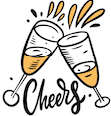
